In [1]:
import os
import gc
import re

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import wordcloud

from matplotlib.pyplot import figure
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
# !pip install pyarrow
# !pip install nltk
# !pip install wordcloud
# !pip install xgboost

In [4]:
# train = pd.read_csv('c:/data/project/train.csv')
# test = pd.read_csv('c:/data/project/test.csv')

## Data Preprocessing

In [2]:
# # parquet으로 저장 함수, csv보다 매우 빠르게 데이터 처리가 가능합니다 :)
## Convert CSV files to Parquet format for faster data reading and processing
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()                            #garbage collect
    print(save_name, 'Done.')

In [3]:
csv_to_parquet('c:/data/project/train.csv', 'train')
csv_to_parquet('c:/data/project/test.csv', 'test')

train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
# sample_submission = pd.read_csv('c:/data/project/sample_submission.csv', index_col = 0)

train Done.
test Done.


In [4]:
# train 복사
train1 = train.copy()
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


In [5]:
train1.drop(columns=['ID','first_party', 'second_party'], inplace=True)

In [7]:
print(train1['first_party_winner'].value_counts())
train1.head()

first_party_winner
1    1649
0     829
Name: count, dtype: int64


,facts,first_party_winner
0,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,Ramon Nelson was riding his bike when he suffe...,0
2,An Alabama state court convicted Billy Joe Mag...,1
3,Victor Linkletter was convicted in state court...,0
4,"On April 24, 1953 in Selma, Alabama, an intrud...",1


## 자연어처리

In [9]:

df = train1[['facts', 'first_party_winner']]
df_target = df[['first_party_winner']]

df_nlp = pd.DataFrame(df[['facts']], columns=['facts'])
# df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True) # 특수문자 제거
df_nlp['facts'] = df_nlp['facts'].str.replace(r'\d', '', regex=True)       # 숫자 제거
df_nlp['facts'] = df_nlp['facts'].str.replace(r'[^\w\s]', '', regex=True)

df_nlp

,facts
0,On June Phil St Amant a candidate for public...
1,Ramon Nelson was riding his bike when he suffe...
2,An Alabama state court convicted Billy Joe Mag...
3,Victor Linkletter was convicted in state court...
4,On April in Selma Alabama an intruder broke ...
...,...
2473,Congress amended the Clean Air Act through the...
2474,Alliance Bond Fund Inc an investment fund purc...
2475,In the District Court sentenced Manuel D Pegu...
2476,On March Enrico St Cyr a lawful permanent re...


In [10]:
df_target.value_counts()

first_party_winner
1                     1649
0                      829
Name: count, dtype: int64

In [12]:
# import nltk
# nltk.download()

In [12]:
# from nltk.tokenize import WhitespaceTokenizer
# # 공백 단위로 쪼개기
# corpus = df_nlp1["facts"]
# Tokenizer=WhitespaceTokenizer()
# lst_tokens = Tokenizer.tokenize(str(corpus))
# lst_tokens

In [14]:

# 사용자 불용어 + 기본 제공 불용어 생성
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None, user_stopwords=None): 
## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
        
    if user_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    user_stopwords]
                        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [15]:
# 사용자 불용어 제작
user_stopwords = set(["appeal","held","state","supreme","federal","circuit","district", "law", "court", "case", "plaintiff", "defendant",
                "judge", "trial", "jurisdiction", "evidence", "witness", "proceeding",
                "litigation", "party", "motion", "action", "suit", "claim", "issue",
                "fact", "hearing", "judgment", "order", "allegation", "argument",
                "brief", "charge", "complaint", "contract", "crime", "decision", "defense",
                "document", "file", "find", "hold", "injunction", "instruction", "lawyer", "legal",
                "liability", "matter", "notice", "opinion", "plea", "point", "policy", "practice",
                "present", "prosecution", "record", "rule", "sentence", "statute", "testimony", "verdict",
                'james', 'bike', 'named',"section", "act", "article", "chapter", "provision", "paragraph"
                "amendment", "code", "regulation", "statutory", "subsection", "constitution", "legislation",
                "ordinance", "regulatory", "rulemaking", "title", "enactment", "resolution", "treaty",
                "administrative", "bylaw",  "legislative", "prescription", "ratification", "repeal",
                "statutorily", "adjudicate", "adjudication", "arbitrate", "arbitration", "conciliation",
                "decree", "litigate", "mediation", "remand", "tribunal", "appellate", "affirm", "overrule",
                "reversal", "vacate", "writ", "certiorari", "mandamus", "subpoena", "arraignment",
                "indictment", "misdemeanor", "probation", "restitution", "summons", "verdict", "acquittal",
                "bail", "contempt", "conviction", "felony", "parole", "sentence",
                "attorney", "barrister", "counsel", "juror", "litigator", "magistrate", "prosecutor",
                "solicitor", "stipulation", "testator", "trustee", "executor", "heir", "lease", "lessor",
                "lessee", "mortgagee", "mortgagor", "assignee", "assignor", "debtor", "creditor", "insurer",
                "insured", "beneficiary", "fiduciary", "principal", "agent"])

In [16]:
# NLTK가 제공 기본 불용어
lst_stopwords = nltk.corpus.stopwords.words("english")

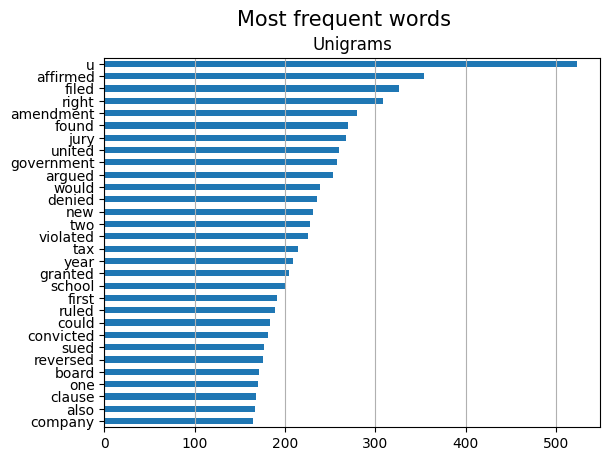

<Figure size 3000x2400 with 0 Axes>

1     ramon nelson riding suffered lethal blow back ...
3     victor linkletter convicted illegally obtained...
14    thole others brought class lawsuit u bank alle...
16    revision texas education law allowed withhold ...
21    maher kara joined citigroups healthcare invest...
Name: facts_clean, dtype: object


In [29]:
df_nlp["facts_clean"] = df_nlp["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords, user_stopwords=user_stopwords))
df_nlp2 = df_nlp.join(df_target)
def freq(n):
    corpus = df_nlp2[df_nlp2["first_party_winner"]== n]["facts_clean"]
    temp = corpus.str.cat(sep=" ")
    wdTmp = utils_preprocess_text(temp, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords, user_stopwords=user_stopwords)
    lst_tokens = nltk.tokenize.word_tokenize(wdTmp)
    fig, ax = plt.subplots(1, 1)
    fig.suptitle("Most frequent words", fontsize=15)
    figure(figsize=(30, 24))
    ## unigrams
    dic_words_freq = nltk.FreqDist(lst_tokens)
    dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
    dtf_uni.set_index("Word").iloc[:30,:].sort_values(by="Freq").plot(
                        kind="barh", title="Unigrams", ax=ax, 
                        legend=False).grid(axis='x')

    ax.set(ylabel=None)
    plt.show()
    print(corpus.head())
    newL = []
    # n회 미만 단어 제거
    
    for word, freK in dic_words_freq.most_common(50):
        newL.append(word)
        
    return newL
lost = freq(0)

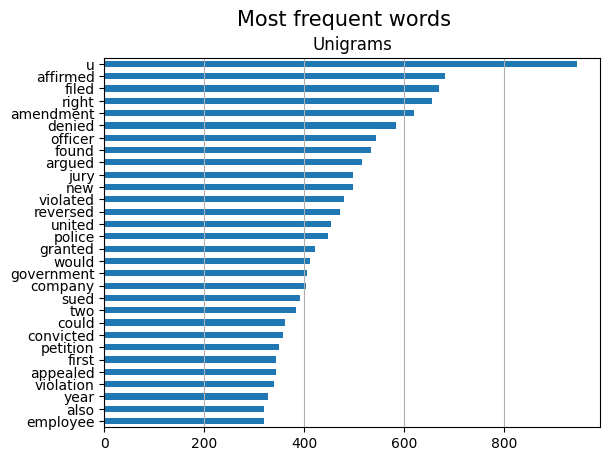

<Figure size 3000x2400 with 0 Axes>

0    june phil st amant candidate public office mad...
2    alabama convicted billy joe magwood murder sen...
4    april selma alabama intruder broke apartment d...
5    new york town clarkstown allowed contractor co...
6    section immigration nationality require noncit...
Name: facts_clean, dtype: object


In [30]:
won = freq(1)

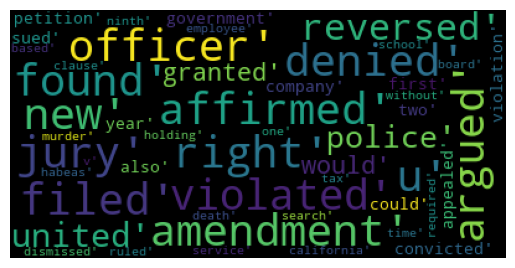

In [31]:
# import wordcloud
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                        max_font_size=35)
wc = wc.generate(str(won))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

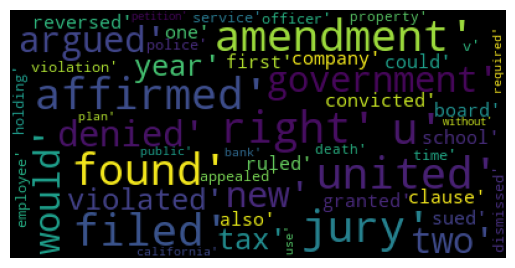

In [32]:
wc0 = wordcloud.WordCloud(background_color='black', max_words=100, 
                        max_font_size=35)
wc0 = wc0.generate(str(lost))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc0, cmap=None)
plt.show()

In [35]:
df_nlp2
xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']

In [36]:
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer()

X_train, X_test, y_train, y_test = train_test_split(xfeatures,ylabel, test_size=0.3)

In [37]:
X_train.count(), X_test.count(), y_train.count(), y_test.count()

(1734, 744, 1734, 744)

In [38]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Preprocessing ENDS && MODELING STARTS

#REGRESSION

In [32]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [33]:
lr.score(X_test, y_test)

0.6760752688172043

#XGBoost

In [34]:
# !pip install xgboost

In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(
                    booster = 'gbtree',
                    scale_pos_weight=5,
                    learning_rate=0.01,  
                    colsample_bytree = 0.7,
                    subsample = 0.5,
                    max_delta_step = 3,
                    reg_lambda = 2,
                    objective='binary:logistic',
                    n_estimators=818, 
                    max_depth=8,
                    )


xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=3,
              max_depth=8, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=818, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [36]:
y_pred = xgb.predict_proba(X_test)
y_pred

array([[0.2748536 , 0.7251464 ],
       [0.0829367 , 0.9170633 ],
       [0.14192772, 0.8580723 ],
       ...,
       [0.17805451, 0.8219455 ],
       [0.09037107, 0.9096289 ],
       [0.25726932, 0.7427307 ]], dtype=float32)

In [37]:
xgb.score(X_test, y_test)

0.6827956989247311

In [38]:
tfidfv = TfidfVectorizer().fit(train['facts'])
print(tfidfv.vocabulary_)
print("="*100)
print(tfidfv.transform(train['facts']).toarray())
print("="*100)
print(tfidfv.fit_transform(train['facts']).toarray())

{'on': 11300, 'june': 8968, '27': 352, '1962': 233, 'phil': 11996, 'st': 14991, 'amant': 1383, 'candidate': 2920, 'for': 6763, 'public': 12745, 'office': 11251, 'made': 9834, 'television': 15696, 'speech': 14902, 'in': 8202, 'baton': 2158, 'rouge': 13907, 'louisiana': 9745, 'during': 5518, 'this': 15846, 'accused': 922, 'his': 7811, 'political': 12180, 'opponent': 11342, 'of': 11235, 'being': 2243, 'communist': 3652, 'and': 1456, 'involved': 8711, 'criminal': 4314, 'activities': 972, 'with': 17250, 'the': 15798, 'head': 7642, 'local': 9656, 'teamsters': 15662, 'union': 16453, 'finally': 6612, 'implicated': 8153, 'herman': 7738, 'thompson': 15850, 'an': 1433, 'east': 5570, 'deputy': 4845, 'sheriff': 14489, 'scheme': 14152, 'to': 15937, 'move': 10652, 'money': 10553, 'between': 2321, 'successfully': 15317, 'sued': 15326, 'defamation': 4640, 'first': 6651, 'circuit': 3355, 'court': 4233, 'appeals': 1564, 'reversed': 13694, 'holding': 7848, 'that': 15797, 'did': 5001, 'not': 11076, 'show':

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
#train_nlp2 = pd.concat([train_nlp,train_target['first_party_winner']],axis=1, join='inner')
xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']

In [40]:
vectorizer = TfidfVectorizer()
def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])
    
    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

In [41]:
X_train = get_vector(vectorizer, train, True)
Y_train = train["first_party_winner"]
X_test = get_vector(vectorizer, test, False)

## Inference & Submission

In [42]:
submit = pd.read_csv('./sample_submission.csv')

In [43]:
pred = model.predict(X_test)

NameError: name 'model' is not defined

In [ ]:
submit['first_party_winner'] = pred
submit.to_csv('./baseline_submit.csv', index=False)
print('Done')

Done
